Current competition metric implies segmenation task. However one valid approach could incorporate object detection. In this direction, and borrowing content from an available kernel [https://www.kaggle.com/kmader/baseline-u-net-model-part-1](http://), we attempt to extract bounding boxes information from binary rle-encoded masks.

In [1]:
! pip install opencv-python

    100% |████████████████████████████████| 25.4MB 2.1MB/s eta 0:00:01
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
! pip install tqdm

    100% |████████████████████████████████| 51kB 30.1MB/s ta 0:00:01
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import os
import cv2
import json
from tqdm import tqdm_notebook
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops
from skimage.util.montage import montage2d as montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import boto3
import io

def get_S3_image(image_name):
    s3 = boto3.resource('s3')
    bucket = s3.Bucket('object-detection-airbus-dataset')
    image_object = bucket.Objexxct(image_name)

    image = mpimg.imread(io.BytesIO(image_object.get()['Body'].read()), 'jpg')
    return image

### Setup

In [3]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::023375022819:role/service-role/AmazonSageMaker-ExecutionRole-20181029T121824
CPU times: user 322 ms, sys: 35.4 ms, total: 358 ms
Wall time: 377 ms


In [4]:
bucket = 'object-detection-airbus-dataset'

In [5]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'object-detection')
print(training_image)

811284229777.dkr.ecr.us-east-1.amazonaws.com/object-detection:1


### Setup S3

In [6]:
%%time

train_channel = 'train'
validation_channel = 'validation'
train_annotation_channel = 'train_annotation'
validation_annotation_channel = 'validation_annotation'

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)
s3_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 7.63 µs


In [7]:
s3_output_location = 's3://{}/output'.format(bucket)

### Define model

In [8]:
od_model = sagemaker.estimator.Estimator.attach('object-detection-2019-03-13-21-42-16-154')

2019-03-14 05:14:28 Starting - Preparing the instances for training
2019-03-14 05:14:28 Downloading - Downloading input data
2019-03-14 05:14:28 Training - Training image download completed. Training in progress.
2019-03-14 05:14:28 Uploading - Uploading generated training model
2019-03-14 05:14:28 Completed - Training job completedDocker entrypoint called with argument(s): train
[03/13/2019 21:59:38 INFO 140535572244288] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'early_stopping_patience': u'5', u'momentum': u'0.9', u'num_training_samples': u'', u'optimizer': u'sgd', u'_tuning_objective

In [9]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_annotation': train_annotation, 'validation_annotation':validation_annotation}

### Hosting

In [84]:
object_detector = od_model.deploy(initial_instance_count = 1,
                                  instance_type = 'ml.p3.2xlarge',
                                  update_endpoint=True)

INFO:sagemaker:Creating model with name: object-detection-2019-03-14-18-36-18-669
INFO:sagemaker:Creating endpoint-config with name object-detection-2019-03-14-18-36-18-669


### Inference

In [94]:
object_categories = ['ship']
threshold = 0.25

# Get filenames
file_names = os.listdir("../validation_images/")

width = 768
height = 768
thresh = 0.2

# Cycle through validation images
for file_name in tqdm_notebook(file_names[5000:]):
    
    img_file_name = "../validation_images/"+file_name
    
    # Read image
    with open(img_file_name, "rb") as image:
        f = image.read()
        b = bytearray(f)
    
    # Get prediction
    object_detector.content_type = "image/jpeg"
    results = object_detector.predict(b)
    detections = json.loads(results)["prediction"]
    
    # Save detections to individual json files
    pred_file_name = "../validation_prediction/"+file_name.split('.')[0]+'.json'
    line = {}
    line['file'] = file_name
    line['image_size'] = [{
        'width':width,
        'height':height,
        'depth':3
    }]
    line['predictions'] = []
    for det in detections:
        (class_id, score, x0, y0, x1, y1) = det
        if score < thresh:
            continue
        xmin = int(x0 * width)
        ymin = int(y0 * height)
        xmax = int(x1 * width)
        ymax = int(y1 * height)
        line['predictions'].append({
            'class_id': class_id,
            'score': score,
            'top': ymin,
            'left': xmin,
            'width': xmax-xmin,
            'height': ymax-ymin
        })
    with open(pred_file_name,'w') as p:
        json.dump(line,p)

In [131]:
tmp

{'file': 'e747bca4c.jpg',
 'image_size': [{'width': 768, 'height': 768, 'depth': 3}],
 'annotations': [{'class_id': 0,
   'top': 462,
   'left': 641,
   'width': 127,
   'height': 105}],
 'categories': [{'class_id': 0, 'name': 'ship'}]}

In [130]:
tmp_pred['predictions']

[{'class_id': 0.0,
  'score': 0.9999741315841675,
  'top': 462,
  'left': 639,
  'width': 129,
  'height': 100},
 {'class_id': 0.0,
  'score': 0.20355364680290222,
  'top': 231,
  'left': 26,
  'width': 12,
  'height': 10},
 {'class_id': 0.0,
  'score': 0.1826201230287552,
  'top': 199,
  'left': 84,
  'width': 11,
  'height': 11},
 {'class_id': 0.0,
  'score': 0.17412084341049194,
  'top': 589,
  'left': 15,
  'width': 8,
  'height': 11},
 {'class_id': 0.0,
  'score': 0.16650360822677612,
  'top': 221,
  'left': 54,
  'width': 12,
  'height': 10},
 {'class_id': 0.0,
  'score': 0.15679174661636353,
  'top': 234,
  'left': 6,
  'width': 10,
  'height': 9},
 {'class_id': 0.0,
  'score': 0.1498548984527588,
  'top': 208,
  'left': 72,
  'width': 8,
  'height': 9},
 {'class_id': 0.0,
  'score': 0.1422578990459442,
  'top': 669,
  'left': 520,
  'width': 11,
  'height': 8},
 {'class_id': 0.0,
  'score': 0.1386370211839676,
  'top': 354,
  'left': 675,
  'width': 11,
  'height': 9},
 {'class

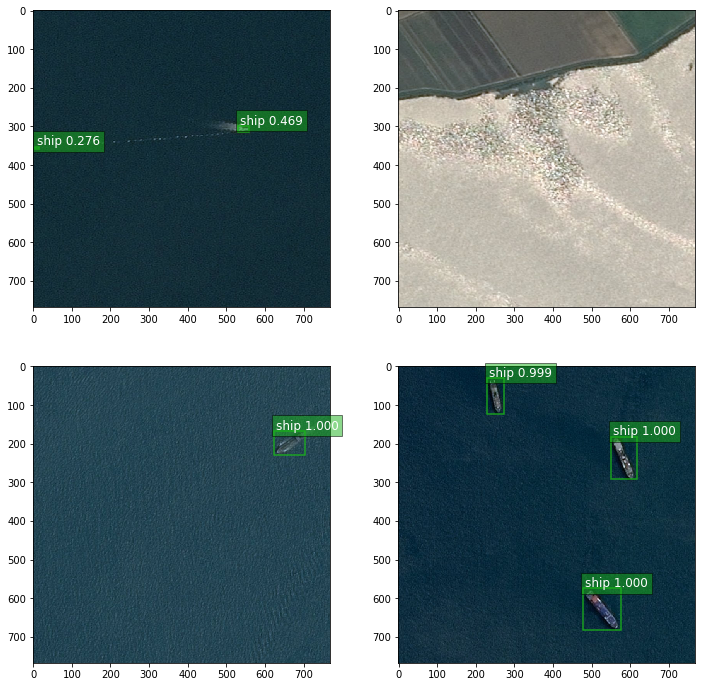

In [190]:
object_categories = ['ship']
# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.25

file_names = np.random.choice(os.listdir("../validation_images/"), 4)
fig, axes = plt.subplots(2,2, figsize=(12,12))
ax = axes.ravel()

for i, file_name in enumerate(file_names):
    
    file_name = "../validation_images/"+file_name
    
    with open(file_name, 'rb') as image:
        f = image.read()
        b = bytearray(f)
#         ne = open('../n.txt','wb')
#         ne.write(b)
        
    object_detector.content_type = 'image/jpeg'
    results = object_detector.predict(b)
    detections = json.loads(results)

    # Visualize the detections.
    plot_file_name = "pred_5.png"
    visualize_detection(file_name, detections['prediction'], ax[i], object_categories, threshold, plot_file_name)

In [139]:
def visualize_detection(img_file, dets, ax, classes=[], thresh=0.6, plot_filename=None):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        ax.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (0.1, 0.7, 0.1)
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=1.5,
                                 alpha=0.85)
            ax.add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            ax.text(xmin + 5, ymin - 5,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.savefig(plot_file_name, bbox_inches="tight")

'/home/ec2-user/SageMaker/sagemaker-object-detection'

### Delete the Endpoint